In [315]:
import pandas as pd

import matplotlib.pyplot as plt

from IPython.display import Image, display

import random

import numpy as np



In [2]:
PATH = "./petfinder-pawpularity-score/train.csv" #Put the path to your train.csv file here

In [12]:
total_data = pd.read_csv(PATH)
total_data

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,0,0,1,15
9908,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,0,0,0,70
9909,ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,1,0,0,20
9910,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,0,0,0,20


In [13]:
df_no_id = total_data.drop(columns=["Id"])
df_no_id

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0,1,1,1,0,0,0,0,0,0,0,0,15
4,0,0,0,1,0,0,1,0,0,0,0,0,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,0,0,0,1,0,0,0,0,0,0,0,1,15
9908,0,1,1,1,0,0,0,0,0,0,0,0,70
9909,0,1,1,1,0,0,0,0,1,1,0,0,20
9910,0,1,1,1,0,0,0,0,1,0,0,0,20


In [6]:
X_train = df_no_id.drop(columns = ['Pawpularity'])
y_train = df_no_id[['Pawpularity']]

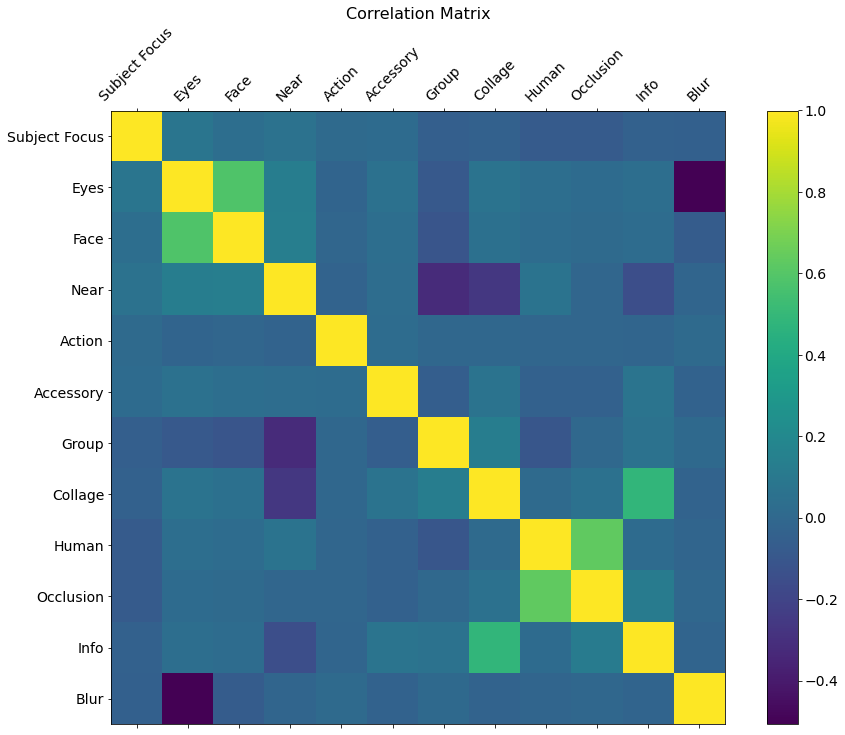

In [7]:
f = plt.figure(figsize=(15, 11))
plt.matshow(X_train.corr(), fignum=f.number)
plt.xticks(range(X_train.select_dtypes(['number']).shape[1]), X_train.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(X_train.select_dtypes(['number']).shape[1]), X_train.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

Ici j'ai juste fait une matrice de corrélation pour voir si certaines variables étaient corrélées. On voit par exemple qu'on voit souvent les yeux si on voit la tête de l'animal (dans certaines photos, on voit la tête de l'animal mais il a les yeux fermés donc pas 1 de coef de corrélation). On voit aussi que les photos de groupe sont prise plus loin (logique) et idem pour les collages.

Idée : effectuer une pca pour tenter d'expliquer la variance mais avec moins de variables (pas forcément utile ici car on a peu de features mais possible, le défaut étant l'étude de l'explicabilité ensuite).

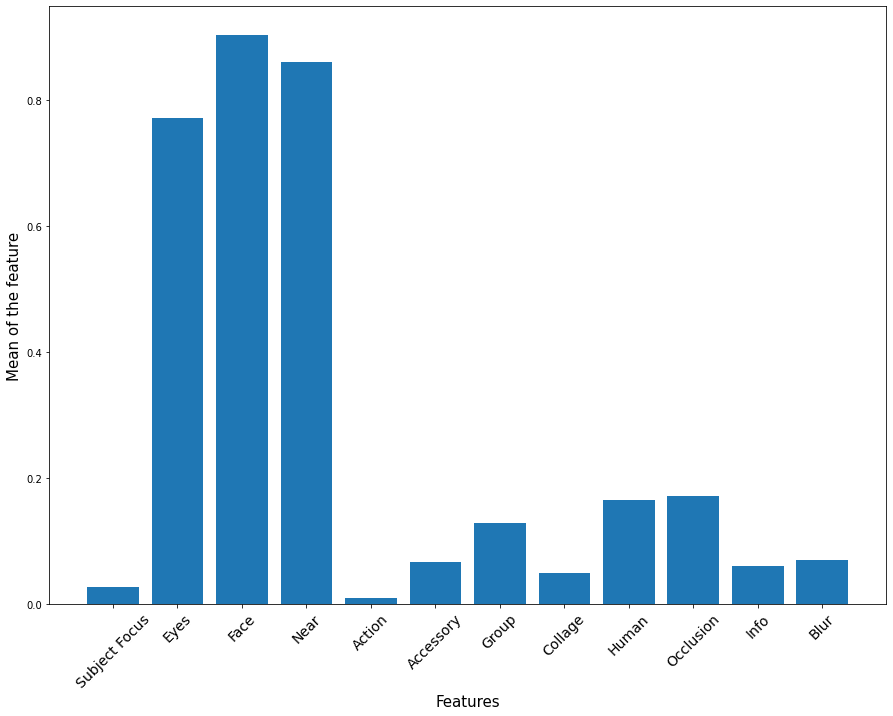

In [265]:
def mean_bar_plot(df):

    mean = df.mean()
    plt.figure(figsize=(15,11))
    plt.bar(range(df.select_dtypes(['number']).shape[1]),mean)
    plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
    plt.xlabel("Features", fontsize= 15)
    plt.ylabel("Mean of the feature", fontsize=15)
    plt.show()

mean_bar_plot(X_train)


Ces moyennes sont juste ici pour voir un peu quelles features sont les plus "actives" dans le dataset. On voit alors que les photos sont plutot des photos d'animaux prises de près sur lesquelles on voit leur visage ainsi que leurs yeux.

<AxesSubplot:ylabel='Frequency'>

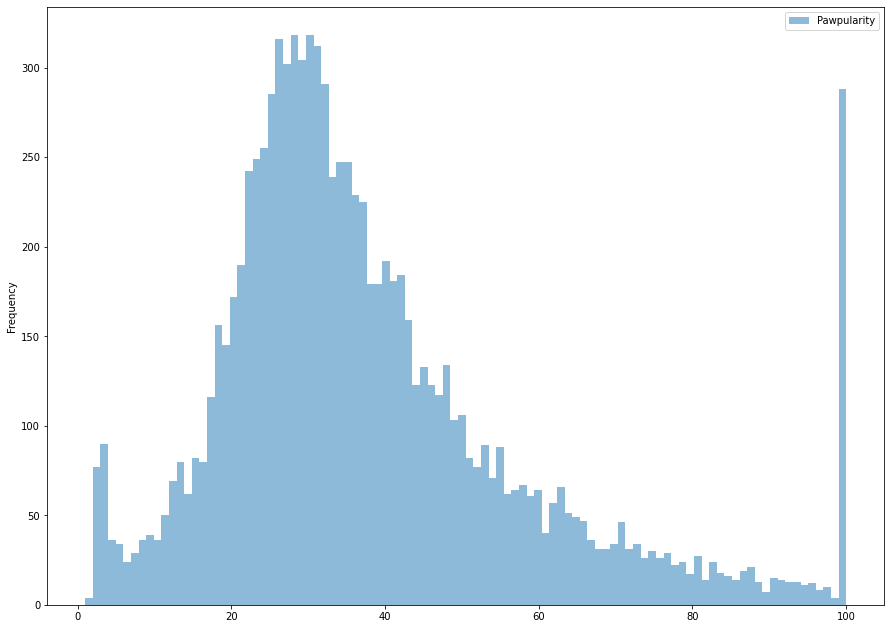

In [9]:
y_train.plot.hist(bins = 100, alpha=0.5, figsize=(15,11))

On voit ici la distribution des scores de pawpularity des animaux. On voit que la note maximale est donnée beaucoup de fois.

Idée : traiter d'abord si la photo a une note maximale ou non et si non, lui attribuer un score de manière continue entre 0 et 100 (exclu). Donc un premier classifier pour 100 ou non et un régresseur pour le score ensuite.

In [10]:
class_df =df_no_id.copy()
class_df.loc[class_df.Pawpularity != 100, 'Pawpularity'] = 0 #Score < 100
class_df.loc[class_df.Pawpularity == 100, 'Pawpularity'] = 1 #Score = 100
class_df


,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0,1,1,1,0,0,1,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,0,0,0
2,0,1,1,1,0,0,0,0,1,1,0,0,0
3,0,1,1,1,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,0,0,0,1,0,0,0,0,0,0,0,1,0
9908,0,1,1,1,0,0,0,0,0,0,0,0,0
9909,0,1,1,1,0,0,0,0,1,1,0,0,0
9910,0,1,1,1,0,0,0,0,1,0,0,0,0


In [31]:
def show(image_ID):
    image = Image(filename = './petfinder-pawpularity-score/train/'+str(image_ID)+'.jpg')
    display(image)

In [138]:
def filter( df,
            Subject_Focus = None, Eyes = None, Face = None, Near = None, Action = None, Accessory = None, Group = None, Collage = None, Human = None, Occlusion = None, Info = None, Blur = None, Pawpularity_min = None, Pawpularity_max = None):

    res = df.copy()

    if Subject_Focus != None :
        res = df.loc[res['Subject Focus'] == Subject_Focus]
    if Eyes != None :
        res = res.loc[res['Eyes'] == Eyes]
    if Face != None :
        res = res.loc[res['Face'] == Face]
    if Near != None :
        res = res.loc[res['Near'] == Near]
    if Action != None :
        res = res.loc[res['Action'] == Action]
    if Accessory != None :
        res = res.loc[res['Accessory'] == Accessory]
    if Group != None :
        res = res.loc[res['Group'] == Group]
    if Collage != None :
        res = res.loc[res['Collage'] == Collage]
    if Human != None :
        res = res.loc[res['Human'] == Human]
    if Occlusion != None :
        res = res.loc[res['Occlusion'] == Occlusion]
    if Info != None :
        res = res.loc[res['Info'] == Info]
    if Blur != None :
        res = res.loc[res['Blur'] == Blur]
    if Pawpularity_min != None :
        res = res.loc[res['Pawpularity'] >= Pawpularity_min]
    if Pawpularity_max != None :
        res = res.loc[res['Pawpularity'] <= Pawpularity_max]

    return res.reset_index(drop = True)

On définit une fonction filter pour filtrer les données du dataset.

Subject_Focus (0 ou 1) : aucune idée, peut être définit si le sujet de la photo est bien l'animal et que la mise au point est impec ?

Eyes (0 ou 1) : définit la visibilité des yeux de l'animal (ou des animaux) pris en photo, 1 signifie oui et 0 non.

Face (0 ou 1) : définit si l'animal fait face à l'objectif photo, 1 signifie que l'animal fait face et 0 le cas contraire.

Near (0 ou 1) : définit la distance de l'animal à l'objectif photo, 1 signifie proche et 0 loin.

Action (0 ou 1) : définit si l'animal est en train d'effectuer une action (1) ou non (0).

Accessory (0 ou 1) : définit si l'animal possède un accessoire (1) ou non (0).

Group (0 ou 1) : définit si la photo est une photo de groupe (1) ou de l'animal seul (0).

Collage (0 ou 1) : définit si la photo est un collage (1) ou non (0).

Human (0 ou 1) : définit si la photo contient un humain  (1) ou non (0).

Occlusion (0 ou 1) : définit si l'animal est visible en entier (0) ou si il y a un obstacle devant (1).

Info (0 ou 1) : définit si des informations sont affichées (1) ou non (0).

Blur (0 ou 1) : définit si la photo est floue (1) ou non (0).

Pawpularity(valeur allant de 0 à 100) : définit le score de "pawpularity" de l'animal pris en photo.

In [231]:
filtered_df = filter(total_data, Pawpularity_min=100)

filtered_df

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,00768659c1c90409f81dcdecbd270513,0,1,1,0,0,0,0,0,0,0,0,0,100
1,013f86ed0e765b189990d3d5ac28bd7d,0,0,0,1,0,0,1,0,0,0,0,0,100
2,0254f54b148543442373d5aad45b2d1a,0,1,1,1,0,0,0,0,0,0,0,0,100
3,04fef9f129bc6e4b90644d4290fde8c3,0,1,1,1,0,0,0,0,0,0,0,0,100
4,063d79b149f4d163eae86f777a39a42f,0,0,1,1,0,0,0,0,0,0,0,1,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,fa27d0eeeec835a00853d382f8777b19,0,1,1,1,0,0,0,0,0,0,0,0,100
284,fb1b85c23f5cc8a079387ff575b67b50,0,1,1,1,0,0,0,0,0,0,1,0,100
285,fde75ba22f491d31c9267e59f6cbfe1a,0,1,1,1,0,0,0,0,0,0,0,0,100
286,fe200aff478f55ca4bcf77d9dade1217,0,1,1,1,0,0,0,0,0,0,0,0,100


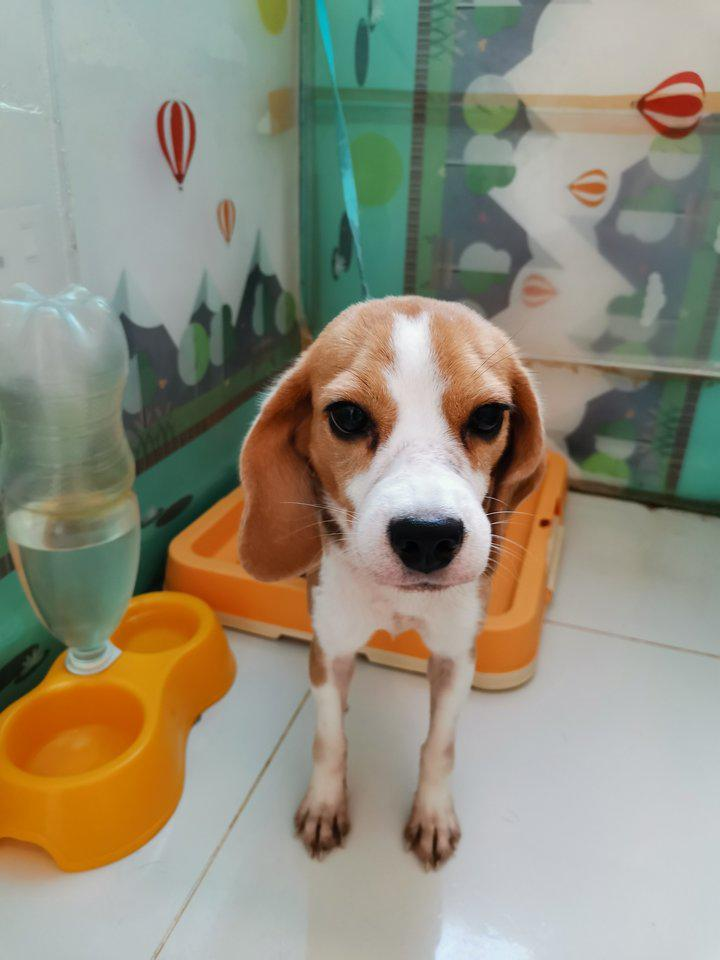

In [264]:
def display_random_picture(filtered_df):

    index = random.randint(0,len(filtered_df)-1)

    show(filtered_df['Id'][index])

display_random_picture(filtered_df)

Maintenant que l'on comprend mieux comment sont annotées les photos et comment le dataset est construit, essayons de trouver une tendance dans les attributs pour les photos avec bonne "pawpularity".

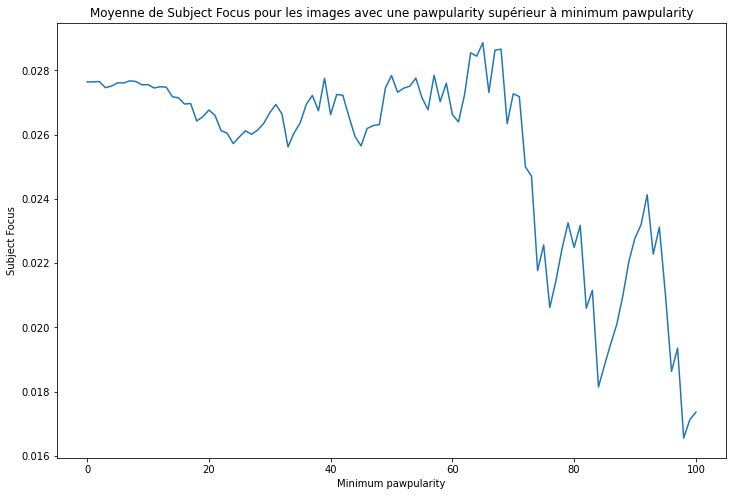

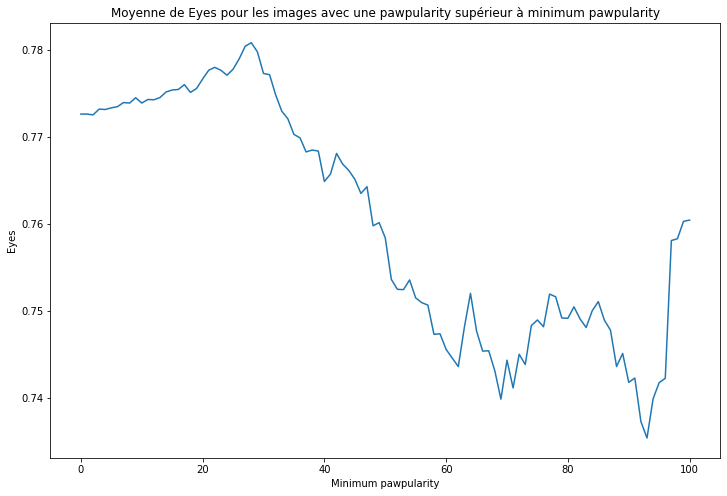

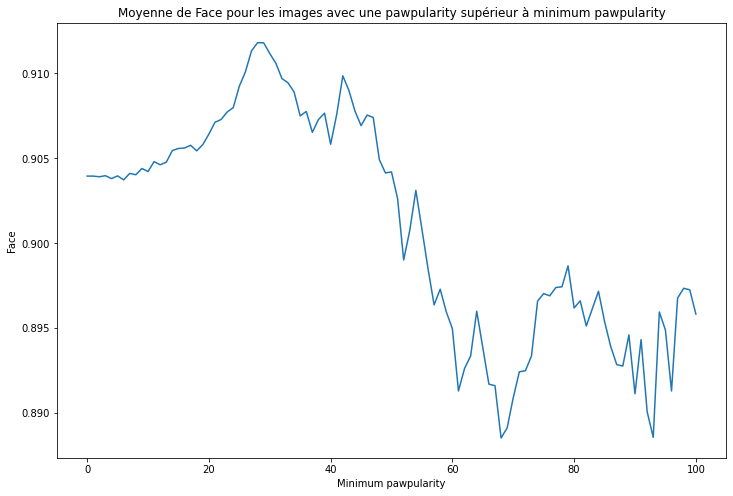

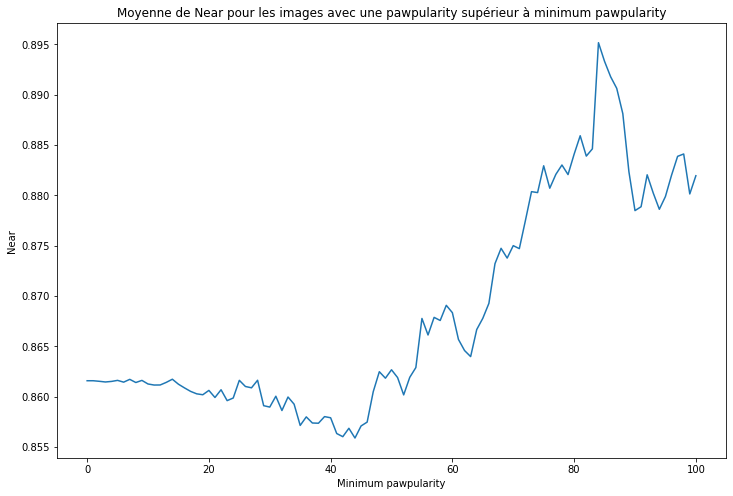

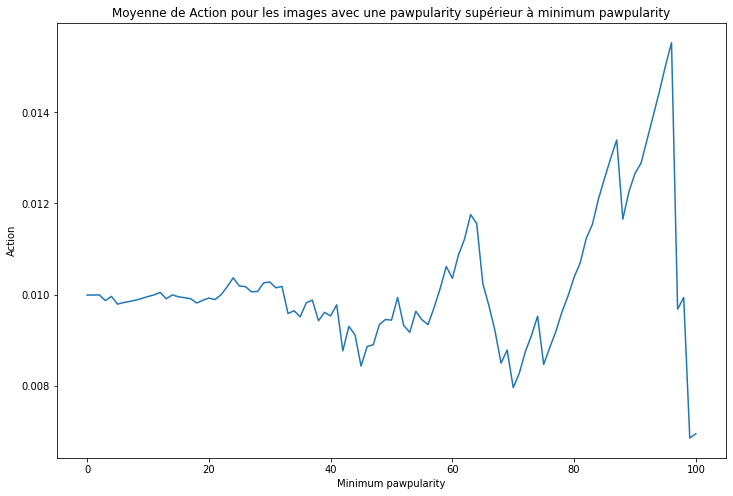

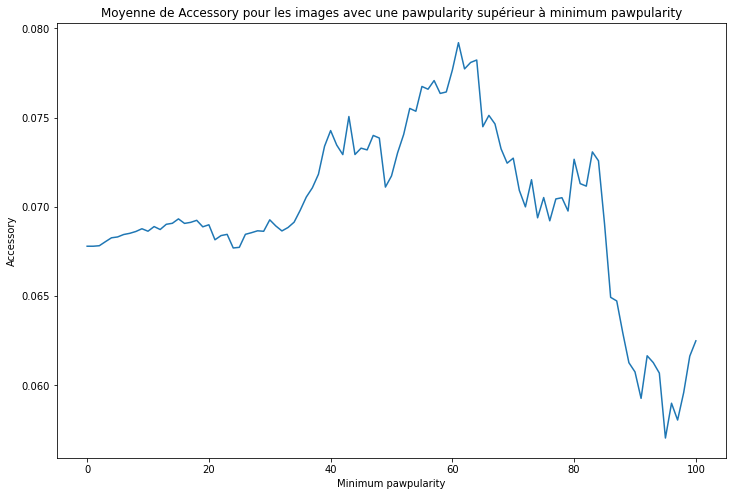

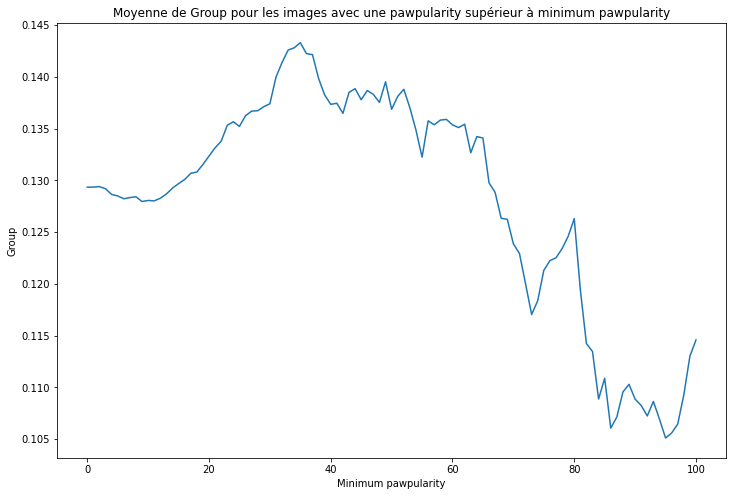

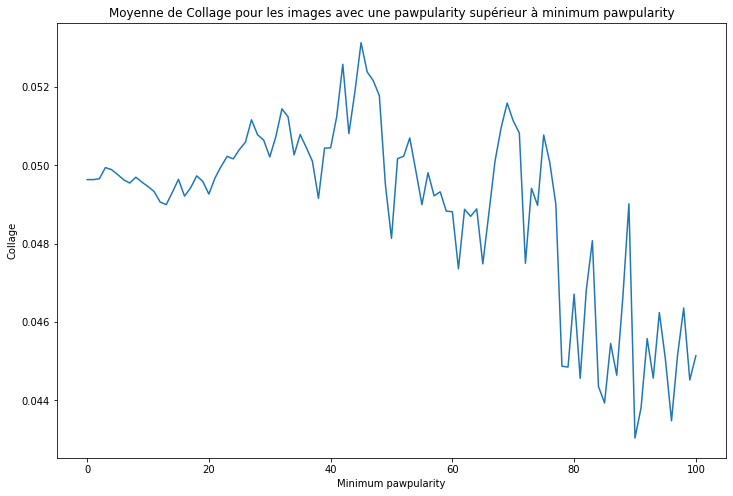

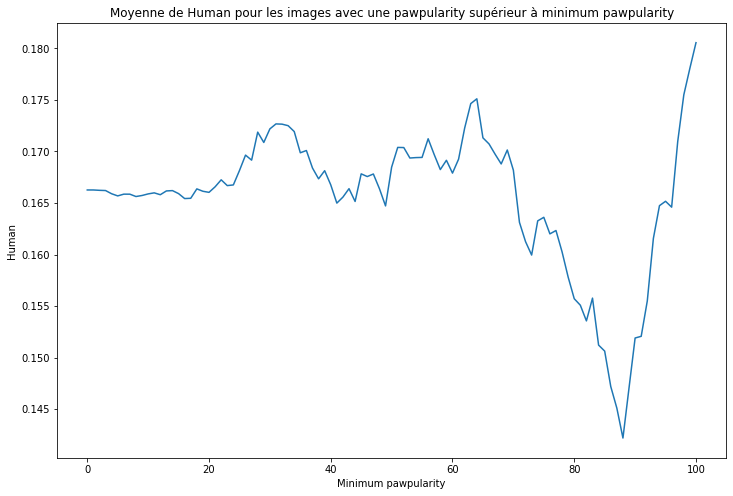

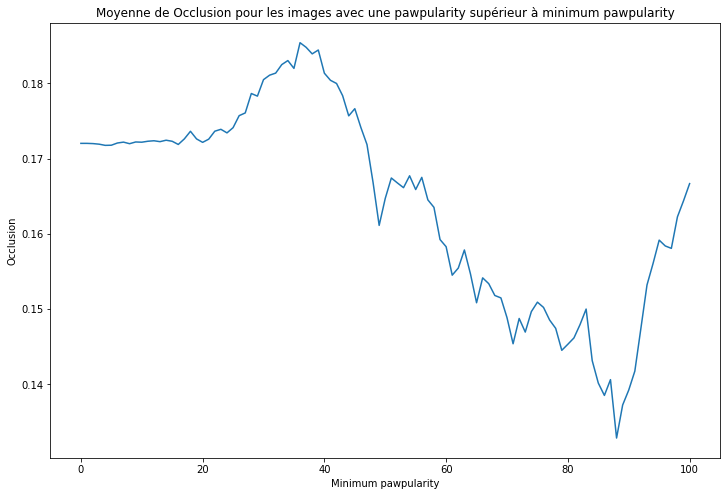

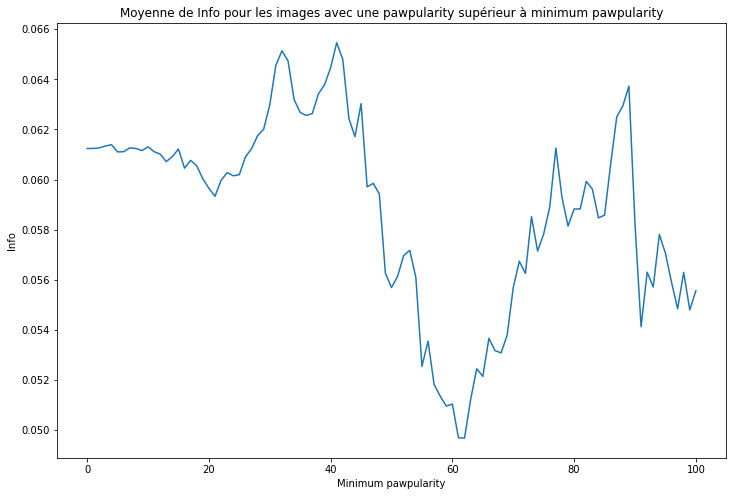

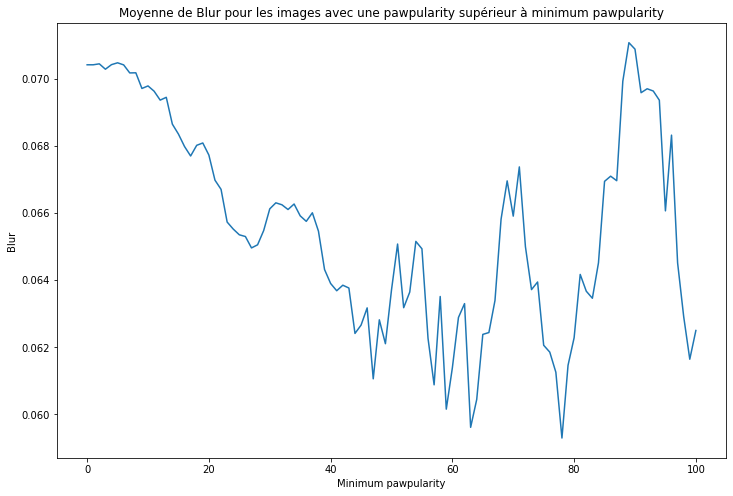

In [319]:
filtered_df = filter(total_data,Pawpularity_min=0).drop(columns = ["Id", "Pawpularity"])
mean = filtered_df.mean().to_frame().T

for Pawpularity_min in range(1,101):
    mean = mean.append(filter(total_data,Pawpularity_min=Pawpularity_min).drop(columns = ["Id", "Pawpularity"]).mean().to_frame().T)

mean.index = np.arange(0,101,1)

for column in mean.columns :
    plt.figure(figsize=(12,8))
    plt.title('Moyenne de ' + column + ' pour les images avec une pawpularity supérieur à minimum pawpularity')
    plt.plot(mean.index, mean[column])
    plt.xlabel('Minimum pawpularity')
    plt.ylabel(column)
    plt.show()
    
    

On vient ici d'afficher l'évolution de la valeur moyenne d'une feature en fonction du minimum de score de "pawpularity". Cela permet de montrer comment impactent les features sur la valeur de la "pawpularity", on voit par exemple que Near augmente et que Eyes diminue (grosso modo). Cela peut donc indiquer que les photos d'animaux avec une "pawpularity" élevée sont prises plus proches de l'animal et avec les yeux moins souvent visibles (en gros). Cependant, ces variations restent assez minimes et l'impact que l'on peut en déduire peut ne pas être vraiment explicatif (en somme c'est pas ouf).